In [40]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import datetime
from IPython import display
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np 

In [41]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [42]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
# TODO
test_images = images[10000:12000]

# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on


In [43]:
# create training and test tf.datasets
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)

<TakeDataset shapes: (784,), types: tf.uint8>
<MapDataset shapes: (28, 28, 1), types: tf.float32>


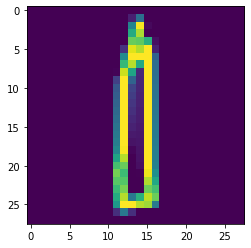

In [44]:
# print original and wanted shape and show image 
temp = test_ds.take(1)
print(temp)
temp = temp.map(lambda image: (tf.cast(tf.reshape(image, [28,28,1]), tf.float32)))
print(temp)
for elem in temp:
  plt.imshow(elem[ :, :, 0])

In [45]:
def prepare(ds):   
  # Prepare data for model  
  ds = ds.map(lambda img: (tf.cast(img, tf.float32)))
  ds = ds.map(lambda img:(tf.reshape(img, [28,28,1])))
  ds = ds.map(lambda img: ((img/128.)-1.))  
  # cache 
  ds = ds.cache()
  # shuffle, batch, prefetch our dataset
  ds = ds.shuffle(5000)
  ds = ds.batch(256)
  ds = ds.prefetch(1024)
  return ds

In [46]:
train_ds = prepare(train_ds)
test_ds = prepare(test_ds)

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, MaxPool2D, Dropout, BatchNormalization, LeakyReLU

In [48]:
class Discriminator(Model):

  def __init__(self):
    super(Discriminator, self).__init__()

    # list of loss and accuracy for training 
    self.metrics_list = [
      tf.keras.metrics.Mean(name="disc_loss"),
      tf.keras.metrics.BinaryAccuracy(name="disc_acc") ]

    self.discriminator = [
      Conv2D(32, (3,3), strides=(2, 2), activation='relu', padding='same', input_shape=[28, 28, 1]),
      BatchNormalization(),
      Dropout(0.3),

      Conv2D(64, (3,3), activation='relu', strides=(2, 2), padding='same'),
      BatchNormalization(),
      Dropout(0.3),

      Conv2D(32, (3,3), activation='relu', strides=(2, 2), padding='same'),
      BatchNormalization(),
      Dropout(0.3),
      
      Flatten(),
      Dense(1, activation='sigmoid')
      ]
  
  @tf.function
  def call(self, x, training=True):

    for layer in self.discriminator:
      x = layer(x, training=training)
    return x

  # function to reset the metric values
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()

In [49]:
class Generator(Model):

  def __init__(self):
    super(Generator, self).__init__()

    # list of loss and accuracy for training 
    self.metrics_list = [
      tf.keras.metrics.Mean(name="gen_loss"),
      tf.keras.metrics.BinaryAccuracy(name="gen_acc") ]

    self.generator = [
      Dense(7*7*256, use_bias=False, input_shape=(100,)),
      BatchNormalization(),
      LeakyReLU(),

      Reshape((7,7,256)),

      Conv2DTranspose(64, (2,2), strides=(1,1), padding='same'),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(128, (2,2), strides=(2,2), padding='same'),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(128, (2,2), strides=(1,1), padding='same'),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(64, (2,2), strides=(1,1), padding='same'),
      BatchNormalization(),
      LeakyReLU(),
      
      Conv2DTranspose(filters= 1, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
      ]

  @tf.function
  def call(self, x, training=True):

    for layer in self.generator:
      x = layer(x, training=training)
    return x

  # function to reset the metric values
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()

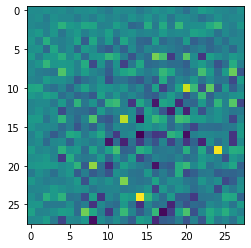

In [50]:
# test generator
sample_generator = Generator()

generated_image = sample_generator(tf.random.normal([1, 100]), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [51]:
#test discriminator on generated image
test_discriminator = Discriminator()
result = test_discriminator(generated_image)
print(result)

tf.Tensor([[0.23463422]], shape=(1, 1), dtype=float32)


In [52]:
def generate_image(model, epoch, test_input):
  # `training` set to False.
  # This is so all layers run in inference mode (batchnorm)

  # get image from generator
  predictions = model(test_input, training=False)

  # plot image
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.show()

In [53]:
def discriminator_loss(real_output, fake_output, loss_func):
  # compute loss for discriminator
  real_loss = loss_func(tf.ones_like(real_output), real_output)
  fake_loss = loss_func(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output, loss_func):
  # compute loss for generator
  return loss_func(tf.ones_like(fake_output), fake_output)

In [54]:
@tf.function
def train_step(images, loss_func):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise)

      real_output = discriminator(images)
      fake_output = discriminator(generated_images)

      gen_loss = generator_loss(fake_output, loss_func)
      disc_loss = discriminator_loss(real_output, fake_output, loss_func)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # update loss metric
    discriminator.metrics[0].update_state(disc_loss)
    generator.metrics[0].update_state(gen_loss)
    
    # for all metrics except loss, update states (accuracy etc.)
    for metric in discriminator.metrics[1:]:
      metric.update_state(tf.ones_like(real_output), real_output)
      metric.update_state(tf.zeros_like(fake_output), fake_output)
    
    for metric in generator.metrics[1:]:
      metric.update_state(tf.ones_like(fake_output), fake_output)

    # Return a dictionary mapping metric names to current value
    disc_metrics = {m.name: m.result() for m in discriminator.metrics}
    gen_metrics = {m.name: m.result() for m in generator.metrics}
    return  gen_metrics , disc_metrics

def test_step(images, loss_func):
  generated_images = generator(noise, training=False)
  
  real_output = discriminator(images, training=False)
  fake_output = discriminator(generated_images, training=False)

  gen_loss = generator_loss(fake_output, loss_func)

  disc_loss = discriminator_loss(real_output, fake_output, loss_func)

  # update loss metric
  discriminator.metrics[0].update_state(disc_loss)
  generator.metrics[0].update_state(gen_loss)
  
  # for all metrics except loss, update states (accuracy etc.)
  for metric in discriminator.metrics[1:]:
    metric.update_state(tf.ones_like(real_output), real_output)
    metric.update_state(tf.zeros_like(fake_output), fake_output)
  
  for metric in generator.metrics[1:]:
    metric.update_state(tf.ones_like(fake_output), fake_output)

  # Return a dictionary mapping metric names to current value
  disc_metrics = {m.name: m.result() for m in discriminator.metrics}
  gen_metrics = {m.name: m.result() for m in generator.metrics}

  return  gen_metrics , disc_metrics

In [55]:
tf.keras.backend.clear_session()
def training(train_data, test_data, loss_function, epochs):
  # train models
  for epoch in range(epochs):
    print()
    print(f"Epoch {epoch}:")
    
    for data in train_data:
        gen_metrics, disc_metrics = train_step(data, loss_function)
                                    
    print("Discriminator")
    print([f"{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    print("Generator")
    print([f"{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])
    
    # logging the validation metrics to the log file with tensorboard
    with train_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
    
    # reset metrics in models
    discriminator.reset_metrics()
    generator.reset_metrics()
    
    # test models
    for data in test_data:
        gen_metrics, disc_metrics = test_step(data, loss_function)
                                
    print("Discriminator")
    print([f"test_{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    print("Generator")
    print([f"test_{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])

    # show generated images                                              
    generate_image(generator, epoch + 1, seed)
    
    # logging the validation metrics to the log file with tensorboard
    with val_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
    
    # reset metrics in models
    discriminator.reset_metrics()
    generator.reset_metrics()

In [56]:
# initialize models 
generator = Generator()
discriminator = Discriminator()

# hyperparameters
BATCH_SIZE = 256

EPOCHS = 50

LOSS_FUNC = tf.keras.losses.BinaryCrossentropy()

gen_optimizer = tf.keras.optimizers.Adam(0.001)
disc_optimizer = tf.keras.optimizers.Adam(0.001)

# additional parameters for noise creation
noise_dim = 100
num_examples_to_generate = 4

noise = tf.random.normal([1, 100])
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [57]:
# Define saving location for log
hyperparameter_string= f"Trial:02_BATCH:{BATCH_SIZE}_EPOCH:{EPOCHS}_Adam"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{hyperparameter_string}/{current_time}/train"
val_log_path = f"logs/{hyperparameter_string}/{current_time}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)


Epoch 0:
Discriminator
['disc_loss: 1.2992302179336548', 'disc_acc: 0.6890810132026672']
Generator
['gen_loss: 0.86109459400177', 'gen_acc: 0.5711914300918579']
Discriminator
['test_disc_loss: 1.300290822982788', 'test_disc_acc: 0.0039840638637542725']
Generator
['test_gen_loss: 1.5418366193771362', 'test_gen_acc: 0.0']


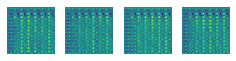


Epoch 1:


KeyboardInterrupt: ignored

In [58]:
# train the GAN 
training(train_ds, test_ds, LOSS_FUNC, EPOCHS)

In [ ]:
#test generator
image = generator(noise, training=False)

plt.imshow(image[0, :, :, 0])

#test discriminator 
result = discriminator(generated_image)
print(result)